1. Khai báo thư viện được sử dụng

In [1]:
import os
import gzip
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf

2. Đọc dữ liệu

(60000, 784)


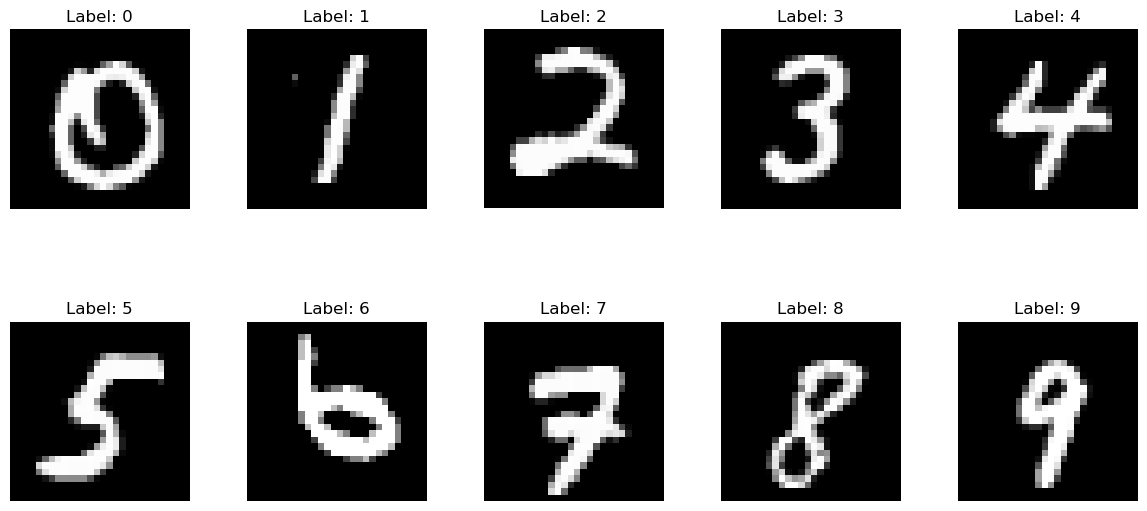

In [2]:
# Đường dẫn đến thư mục chứa dữ liệu
data_path = "C:\\ML-MAT3533\\data_midtern"

# Đường dẫn đến các tệp dữ liệu
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')
val_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
val_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

# Hàm để tải dữ liệu hình ảnh
def load_images(file_path):
    with gzip.open(file_path, 'rb') as f:
        # Bỏ qua 16 byte đầu tiên chứa thông tin metadata
        data = np.frombuffer(f.read(), np.uint8, offset=16)
        # Chuyển dữ liệu thành mảng 2D, mỗi hàng là một hình ảnh
        data = data.reshape(-1, 784)  # 28x28 pixels flattened
    return data

# Hàm để tải nhãn dữ liệu
def load_labels(file_path):
    with gzip.open(file_path, 'rb') as f:
        # Bỏ qua 8 byte đầu tiên chứa thông tin metadata
        labels = np.frombuffer(f.read(), np.uint8, offset=8)
    return labels

# Tải dữ liệu hình ảnh và nhãn
train_images = load_images(train_images_path)
train_labels = load_labels(train_labels_path)
val_images = load_images(val_images_path)
val_labels = load_labels(val_labels_path)

fig, axs = plt.subplots(2, 5, figsize=(12, 6))
fig.tight_layout()
print(train_images.shape)
for label in range(10):
    # Lấy chỉ mục của ảnh có nhãn tương ứng
    indices = np.where(val_labels == label)[0]
    random_index = random.choice(indices)
    
    # Lấy ảnh và hiển thị
    image = val_images[random_index].reshape(28, 28)
    
    axs[label // 5, label % 5].imshow(image, cmap='gray')
    axs[label // 5, label % 5].set_title(f"Label: {label}")
    axs[label // 5, label % 5].axis('off')

plt.show()

3. Thực hiện việc rút gọn số chiều dữ liệu, sau đó tham khảo để hiển thị trực quan các phân lớp dữ liệu dạng 3D hoặc 2D.

Dữ liệu sau khi giảm chiều:
[[ -123.93258866  -312.67426202]
 [-1011.71837587  -294.85703827]
 [   51.84960805   392.17315286]
 ...
 [  178.0534496    160.07821109]
 [ -130.60607208    -5.59193642]
 [  173.43595244   -24.71880226]]
[[ -123.93258866  -312.67426202   -24.51405176]
 [-1011.71837587  -294.85703827   596.33956104]
 [   51.84960805   392.17315286  -188.50974943]
 ...
 [  178.0534496    160.07821109  -257.61308227]
 [ -130.60607208    -5.59193642   513.85867395]
 [  173.43595244   -24.71880226   556.01889393]]


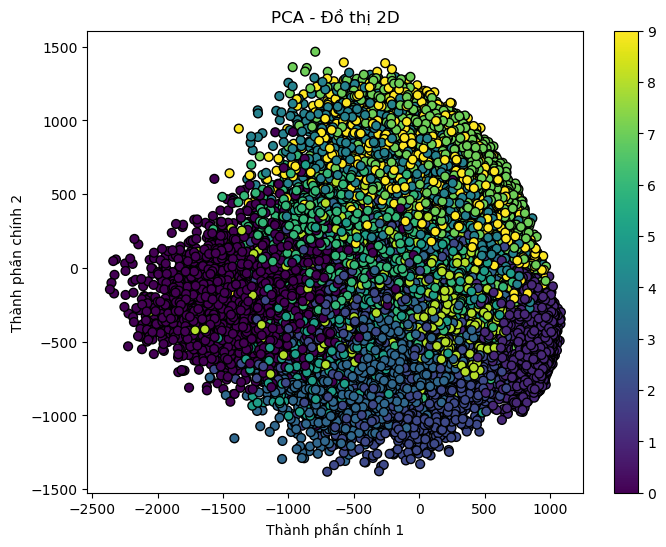

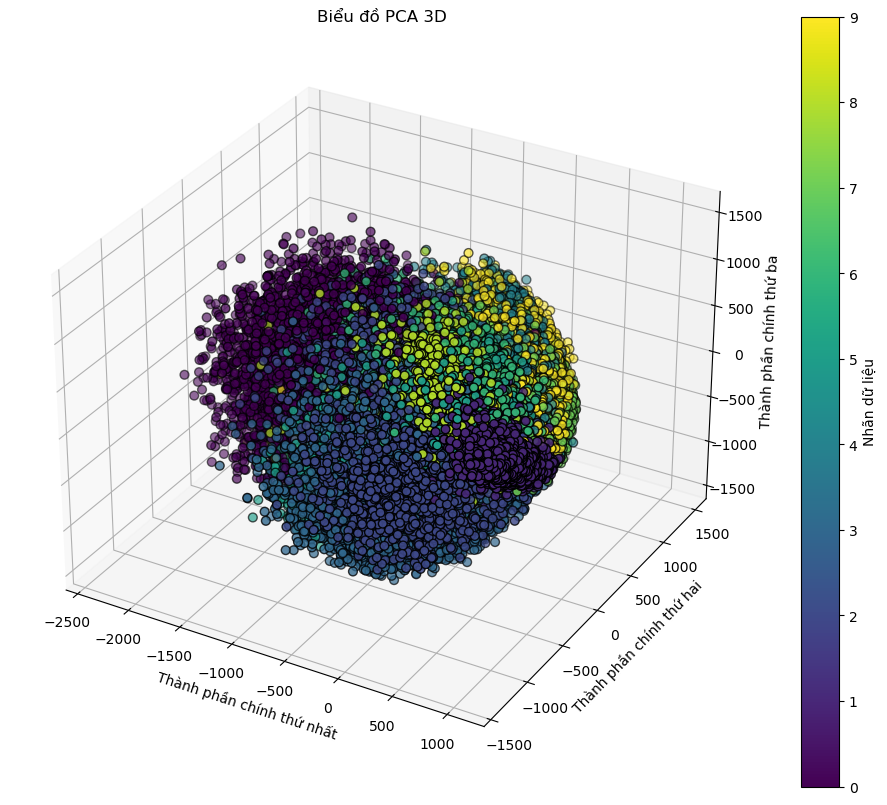

In [3]:
# Sử dụng dữ liệu hình ảnh huấn luyện cho biến X
X = train_images  
y = train_labels

# Chuẩn hóa dữ liệu
X_mean = np.mean(X, axis=0)
X_centered = X - X_mean

# Tính ma trận hiệp phương sai
cov_matrix = np.cov(X_centered, rowvar=False)

# Tính các vector riêng và giá trị riêng
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sắp xếp các vector riêng theo giá trị riêng giảm dần
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues_sorted = eigenvalues[sorted_indices]
eigenvectors_sorted = eigenvectors[:, sorted_indices]

# Chọn số thành phần chính (principal components) cần giữ lại
n_components = [2, 3]
top_eigenvectors_2d = eigenvectors_sorted[:, :n_components[0]]
top_eigenvectors_3d = eigenvectors_sorted[:, :n_components[1]]

# Chiếu dữ liệu lên không gian mới
X_pca_2d = np.dot(X_centered, top_eigenvectors_2d)
X_pca_3d = np.dot(X_centered, top_eigenvectors_3d)

# In ra kết quả
print("Dữ liệu sau khi giảm chiều:")
print(X_pca_2d)
print(X_pca_3d)

# Vẽ đồ thị 2D
plt.figure(figsize=(8,6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='viridis', edgecolor='k', s=40)
plt.title('PCA - Đồ thị 2D')
plt.xlabel('Thành phần chính 1')
plt.ylabel('Thành phần chính 2')
plt.colorbar()
plt.show()

# Vẽ đồ thị 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=y, cmap='viridis', edgecolor='k', s=40)
ax.set_title('Biểu đồ PCA 3D')
ax.set_xlabel('Thành phần chính thứ nhất')
ax.set_ylabel('Thành phần chính thứ hai')
ax.set_zlabel('Thành phần chính thứ ba')
plt.colorbar(scatter, label='Nhãn dữ liệu')
plt.show()

4. Xây dựng chương trình sử dụng mô hình Naïve Bayes phù hợp để phân loại các hình
ảnh, huấn luyện mô hình bằng tập dữ liệu training sau đó chạy kiểm tra với dữ liệu trong
tập validation.

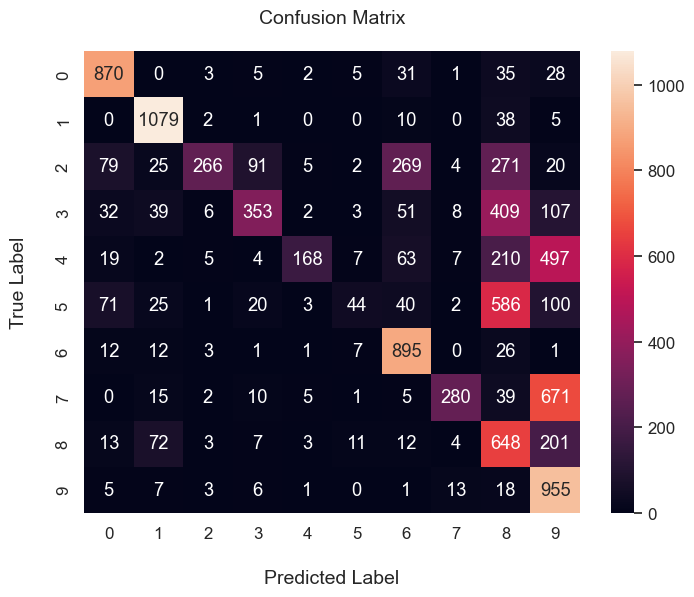

Accuracy (Naive Bayes): 0.5558
Precision (Naive Bayes): 0.6864966027174797
Recall (Naive Bayes): 0.548447051043586
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       980
           1       0.85      0.95      0.90      1135
           2       0.90      0.26      0.40      1032
           3       0.71      0.35      0.47      1010
           4       0.88      0.17      0.29       982
           5       0.55      0.05      0.09       892
           6       0.65      0.93      0.77       958
           7       0.88      0.27      0.42      1028
           8       0.28      0.67      0.40       974
           9       0.37      0.95      0.53      1009

    accuracy                           0.56     10000
   macro avg       0.69      0.55      0.51     10000
weighted avg       0.69      0.56      0.52     10000



In [4]:
nb = GaussianNB()
nb.fit(train_images, train_labels)

# Dự đoán nhãn trên dữ liệu validation
val_pred = nb.predict(val_images)

# Hiển thị các kết quả
plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(confusion_matrix(val_labels, val_pred), annot=True, fmt='d', )
ax.set_xlabel("Predicted Label", fontsize=14, labelpad=20)
ax.set_ylabel("True Label", fontsize=14, labelpad=20)
ax.set_title("Confusion Matrix", fontsize=14, pad=20)
plt.show()

print("Accuracy (Naive Bayes):", accuracy_score(val_labels, val_pred))
print("Precision (Naive Bayes):", precision_score(val_labels, val_pred, average='macro'))
print("Recall (Naive Bayes):", recall_score(val_labels, val_pred, average='macro'))
print(classification_report(val_labels, val_pred))

6. Xây dựng mô hình CNN

Epoch 1/10
469/469 [==============================] - 29s 60ms/step - loss: 0.5793 - accuracy: 0.8586
Epoch 2/10
469/469 [==============================] - 11s 23ms/step - loss: 0.1174 - accuracy: 0.9666
Epoch 3/10
469/469 [==============================] - 14s 31ms/step - loss: 0.0815 - accuracy: 0.9765
Epoch 4/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0655 - accuracy: 0.9804
Epoch 5/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0552 - accuracy: 0.9837
Epoch 6/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0453 - accuracy: 0.9865
Epoch 7/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0391 - accuracy: 0.9882
Epoch 8/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0385 - accuracy: 0.9883
Epoch 9/10
469/469 [==============================] - 18s 38ms/step - loss: 0.0325 - accuracy: 0.9900
Epoch 10/10
313/313 [==============================] - 1s 2ms/step


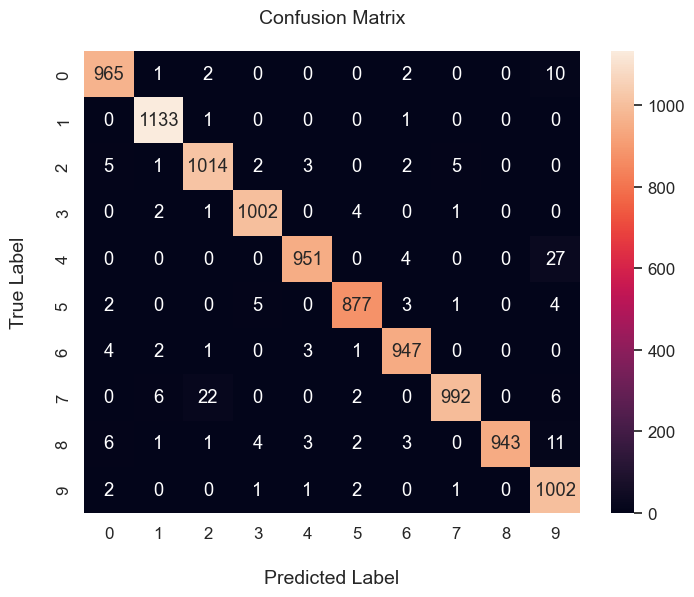

Accuracy (CNN): 0.9826
Precision (CNN): 0.9829538820319541
Recall (CNN): 0.9823917951572454
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      1.00      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.97      0.98       982
           5       0.99      0.98      0.99       892
           6       0.98      0.99      0.99       958
           7       0.99      0.96      0.98      1028
           8       1.00      0.97      0.98       974
           9       0.95      0.99      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [5]:
# Chuyển đổi kích thước dữ liệu ảnh thành 4D (số mẫu, chiều cao, chiều rộng, số kênh)
train_images_reshape = train_images.reshape(-1, 28, 28, 1)
val_images_reshape = val_images.reshape(-1, 28, 28, 1)

# Chuyển đổi nhãn thành one-hot encoding
train_labels_onehot = tf.keras.utils.to_categorical(train_labels)
val_labels_onehot = tf.keras.utils.to_categorical(val_labels)

# Xây dựng mô hình CNN
model = Sequential()

# Tầng tích chập 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Tầng tích chập 2
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Tầng tích chập 3
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dàn phẳng (flatten) dữ liệu trước khi đưa vào fully connected layers
model.add(Flatten())

# Tầng fully connected 1
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

# Tầng fully connected 2
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

# Tầng đầu ra với softmax
model.add(Dense(10, activation='softmax'))

# Compile và huấn luyện mô hình
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_images_reshape, train_labels_onehot, batch_size=128, epochs=10, verbose=1)

# Đánh giá mô hình trên dữ liệu validation
val_pred_cnn = np.argmax(model.predict(val_images_reshape), axis=-1)

# Hiển thị các kết quả
plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(confusion_matrix(val_labels, val_pred_cnn), annot=True, fmt='d', )
ax.set_xlabel("Predicted Label", fontsize=14, labelpad=20)
ax.set_ylabel("True Label", fontsize=14, labelpad=20)
ax.set_title("Confusion Matrix", fontsize=14, pad=20)
plt.show()
print("Accuracy (CNN):", accuracy_score(val_labels, val_pred_cnn))
print("Precision (CNN):", precision_score(val_labels, val_pred_cnn, average='macro'))
print("Recall (CNN):", recall_score(val_labels, val_pred_cnn, average='macro'))
print(classification_report(val_labels, val_pred_cnn))